# AutoGenU for Jupyter

An Automatic C++ Code Generator for Nonlinear Model Predictive Control (NMPC)  

---  

# Generate C++ codes of NMPC model  

## Import modules

In [ ]:
from sympy import *
from AutoGenU_modules import basic_symbolic_func as symfunc
from AutoGenU_modules import cpp_generator as gencpp
init_printing()

## Set dimx, dimu, dimc
`dimx`: dimension of the state vector $x$   
`dimu`: dimension of the control input vector $u$  
`dimc`: dimension of the constraints $C(x, u) = 0$  

In [2]:
dimx = 4
dimu = 1
dimc = 0

## Generate t, x, u, and lmd, necessary variables for the formulation, and basic functions
`t`: time parameter $t$  
`x`: the state vector $x$  
`u`: the control input vector $u$  
`lmd`: the Lagrange multiplier vector for the state equation $\lambda$

In [3]:
t = Symbol('t')
x = symbols(f'x[0:{dimx}]')
u = symbols(f'u[0:{dimu+dimc}]')
lmd = symbols(f'lmd[0:{dimx}]')

## Define user variables used in the state function here
Define a scalar variable whose name is "var" as  
`var = Symbol('var') `

Define scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`var_1, var_2, ..., var_n = symbols('var_1, var_2, ..., var_n')`

Define a vector whose name is "vec" and dimension is dim_vec as  
`vec = symbols(f'vec[0:{dim_vec}]')`

In [4]:
# Define user variables used in the state function here
m1, m2, l1, l2, d1, d2, J1, J2, g = symbols('m1, m2, l1, l2, d1, d2, J1, J2, g')

# You can also define functions used  in the state function or in the cost funciton 

## Define weight parameters used in the stage cost and the terminal cost
`q`: weight array for the state in the stage cost  
`r`: weight array for the control input in the stage cost  
`q_terminal`: weight array for the state in the terminal cost  
`x_ref`: the reference value of the state

In [5]:
q = symbols(f'q[0:{dimx}]')
r = symbols(f'r[0:{dimu+dimc}]')
q_terminal = symbols(f'q_terminal[0:{dimx}]')
x_ref = symbols(f'x_ref[0:{dimx}]')

## Define the state function, constraints, stage cost, terminal cost
`fxu`: state equation $ f(x, u)$  
`Cxu`: equality constraisnts $C(x, u) $  
`L`: stage cost $L(x, u)$  
`phi`: terminal cost $\phi (x)$  
Note: array indices start with 0

In [6]:
# Define the state equation
fxu = [x[2], 
        x[3],
       -(sin(x[0] + x[1]) * d2 * g * m2 + g * (d1 * m1 + l1 * m2) * sin(x[0]) - 0.2e1 * d2 * (x[2] + x[3] / 0.2e1) * l1 * x[3] * m2 * sin(x[1]) - u[0]) / (0.2e1 * d2 * m2 * l1 * cos(x[1]) + d1 * d1 * m1 + d2 * d2 * m2 + l1 * l1 * m2 + J1 + J2), 
       (g * d2 * l1 * m2 * (d1 * m1 + l1 * m2) * sin(x[0] - x[1]) / 0.2e1 - d2 * d2 * g * l1 * m2 * m2 * sin(x[0] + 0.2e1 * x[1]) / 0.2e1 - (d1 * d1 * m1 - d1 * l1 * m1 / 0.2e1 + l1 * l1 * m2 / 0.2e1 + J1) * m2 * g * d2 * sin(x[0] + x[1]) - l1 * l1 * m2 * m2 * d2 * d2 * (pow(x[2], 0.2e1) + x[2] * x[3] + pow(x[3], 0.2e1) / 0.2e1) * sin(0.2e1 * x[1]) - l1 * m2 * d2 * ((pow(x[2] + x[3], 0.2e1) * d2 * d2 + pow(x[2], 0.2e1) * l1 * l1) * m2 + (d1 * d1 * m1 + J1 + J2) * pow(x[2], 0.2e1) + 0.2e1 * J2 * x[2] * x[3] + J2 * pow(x[3], 0.2e1)) * sin(x[1]) + g * (d2 * d2 * l1 * m2 * m2 / 0.2e1 + (d1 * d2 * d2 * m1 + J2 * l1) * m2 + J2 * d1 * m1) * sin(x[0]) - u[0] * (d2 * m2 * l1 * cos(x[1]) + d2 * d2 * m2 + J2)) / (0.2e1 * d2 * m2 * l1 * cos(x[1]) + d1 * d1 * m1 + d2 * d2 * m2 + l1 * l1 * m2 + J1 + J2) / (d2 * d2 * m2 + J2)]

# Define the constraints (if dimc > 0)
Cxu = []

# Define the stage cost
L = sum(q[i]*(x[i] - x_ref[i])**2 for i in range(dimx))/2 + sum(r[i] * u[i]**2 for i in range(dimu))/2 

# Define the terminal cost
phi = sum(q_terminal[i]*(x[i] - x_ref[i])**2 for i in range(dimx))/2

## Generate  optimality conditions
`hamiltonian`: $H(x, u, \lambda) = L(x, u) + \lambda^{\rm T} f(x, u)$  
`hx`: partial derivartive of the hamiltonian $H (x, u, \lambda)$ with respect to $x$, $\left(\frac{\partial H}{\partial x} \right)^{\rm T} (x, u, \lambda)$    
`hu`: partial derivartive of the hamiltonian $H (x, u, \lambda)$ with respect to $u$, $\left(\frac{\partial H}{\partial u} \right)^{\rm T}, (x, u, \lambda)$    
`phix`: partial derivative of the terminal cost $\phi(x)$ with respect to $x$, $\left(\frac{\partial \phi}{\partial x} \right)^{\rm T} (x)$

In [7]:
if(dimc > 0):
    hamiltonian = L + symfunc.dotProduct(lmd, fxu) + sum(u[dimu+i] * Cxu[i] for i in range(dimc))
else:
    hamiltonian = L + symfunc.dotProduct(lmd, fxu) 

phix = symfunc.diffScalarFunc(phi, x)
hx = symfunc.diffScalarFunc(hamiltonian, x)
hu = symfunc.diffScalarFunc(hamiltonian, u)

## Symplify phix, hx, and hu
Note: if `hx` and `hu` is too complicated, it takes too much time to simplify them

In [8]:
phix = simplify(phix)
hx = simplify(hx)
hu = simplify(hu)

## Set Parameters
set all parameters used in the state equation and the cost function

In [9]:
# scalar parameters
scalar_params = [[m1, 0.2], [m2, 0.7], [l1, 0.3], [l2, 0.3], [d1, 0.15], [d2, 0.257], [J1, 0.006], [J2, 0.051], [g, 9.80665]]

# array parameters
array_params = [['q', dimx, '{1, 1, 0.1, 0.1}'], ['r', dimu, '{0.1}'], ['q_terminal', dimx, '{1, 1, 0.1, 0.1}'], ['x_ref', dimx, '{M_PI, 0, 0, 0}']]

## Generate C++ codes of NMPC model
generate `nmpc_model.hpp` and `nmpc_model.cpp` in a directory of `model_name`

In [10]:
model_name = "pendubot"

gencpp.makeModelDir(model_name)
gencpp.generateCpp(dimx, dimu, dimc, fxu, Cxu, phix, hx, hu, model_name)
gencpp.generateHpp(dimx, dimu, dimc, scalar_params, array_params, model_name)

---  
# Generate C++ codes for numerical simulation  

In [11]:
from AutoGenU_modules import solver_params_sets as solverparams
from AutoGenU_modules import simulation_params as simparams
from AutoGenU_modules import cpp_executor as cppexec
from AutoGenU_modules import simulation_plottor as simplot

## Set solvers  
set which solvers you use  in `solver_index`
  
1. The continuation/GMRES method (the original C/GMRES method, single shooting)
2. The multiple shooting based C/GMRES method
3. The multiple shooting based C/GMRES method with condensing of variables with respect to the constraints on the saturation function on the control input

In [12]:
solver_index = 3

## Set saturaions on the control input if you choose `solver_index = 3`
- saturation on the control input: $u_{i, {\rm min}} \leq u_i \leq u_{i, {\rm max}}$  
$u_i \in \mathbb{R}$ : a constrained component of the control input $u$  
- transformed equality constraint: $(u_i - \frac{u_{i, {\rm max}} + u_{i, {\rm min}}}{2})^2 - ( \frac{u_{i, {\rm max}} - u_{i, {\rm min}}}{2})^2 + {u_d}_i ^2 = 0$  
${u_d}_i \in \mathbb{R}$ : a dummy input for the transformation of the saturation into the equality constraint  
- additional term in the stage cost $L(x, u)$ with respect to the saturation of $u_i$: $- {r_d}_i {u_d}_i + \frac{1}{2} {r_q}_i {u_d}_i ^2$  
   ${r_d}_i > 0$: a weight parameter to avoid failure of numerical computation, ${r_q}_i \geq 0$: a weight parameter to increase mergin of the saturation  

`index`: $i$  
`u_min`: $u_{i, {\rm min}}$  
`u_max`: $u_{i, {\rm max}}$   
`dummy_weight`: ${r_d}_i > 0$  
`quadratic_weight` :  ${r_q}_i \geq 0$  
`saturation_param` = [`index`, `u_min`, `u_max`, `dummy_weight`, `quadratic_weight`]

In [13]:
saturation_list = [[0, -5, 5, 1.0e-01, 0]]
# saturation_list = [[index , u_min, u_max, dummy_weight, quadratic_weight], [index , u_min, u_max, dummy_weight, quadratic_weight], .., []]

## Set parameters for the solver

`T_f`, `alpha`: parameters for the length of the horizon $T(t)$: $T(t) = T_f (1 - e^{-\alpha t})$  
`horizon_division_num`: the division number of the horzion for numerical computation  
`difference_incremenet`: difference increment for the forward difference approximation  
`zeta`: a stabilization parameter for the continuation transformation   
`max_dim_krylov`: the maximam number of the iteration of the GMRES  

In [14]:
T_f = 1.0
alpha = 1.0
horizon_division_num = 50
difference_increment = 1.0e-08
zeta = 1000
max_dim_krylov = 3

solver_params = solverparams.SolverParams(T_f, alpha, horizon_division_num, difference_increment, zeta, max_dim_krylov)

## Set parameters for the initialization of the solution  
`initial_guess_solution`: the initial guess of the solution  
`convergence_radius`: the convergence radius of Newton's method for the initialization of the solution  
`maximum_itr_newton`: maximum number of iterations in Newton's method for the initizalization of the solution  
`initial_guess_lagrange_multiplier`: the initial guess of the lagrange multiplier for the condensed constraints with respect to the saturation on the function of the control input

In [15]:
initial_guess_solution = [0.0]
convergence_radius = 1.0e-06
maximum_itr_newton = 50
initial_guess_lagrange_multiplier = [0.01]

if solver_index == 1 or solver_index == 2:
    initialization_params = solverparams.InitializationParams(initial_guess_solution, convergence_radius, maximum_itr_newton)
else:
    initialization_params = solverparams.InitializationParams(initial_guess_solution, convergence_radius, maximum_itr_newton, initial_guess_lagrange_multiplier)

## Set parameters for numerical simulation
`initial_time`: initial time of the numerical simulation  
`initial_state`: initial state vector of the system  
`simulation_time`: simulation time of the numerical simulation  
`sampling_time`: the sampling time of the numerical simulation

In [16]:
initial_time = 0  
initial_state = [0, 0, 0, 0]  
simulation_time = 10
sampling_time = 0.001  

simulation_params = simparams.SimulationParams(initial_time, initial_state, simulation_time, sampling_time)

## Generate main.cpp and CMakeLists.txt

In [17]:
if solver_index == 1 or solver_index == 2:
    gencpp.generateMain(solver_index, solver_params, initialization_params, simulation_params, model_name)
else:
    gencpp.generateMain(solver_index, solver_params, initialization_params, simulation_params, model_name, saturation_list)    

gencpp.generateCMake(solver_index, model_name)
gencpp.generateCMakeForModel(model_name)

## Make files and run simulation

In [18]:
cppexec.setCMake(model_name)
cppexec.makeAndRun(model_name)

## Plot simulation data

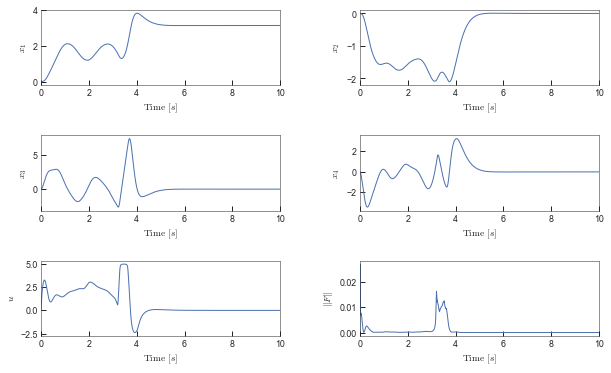

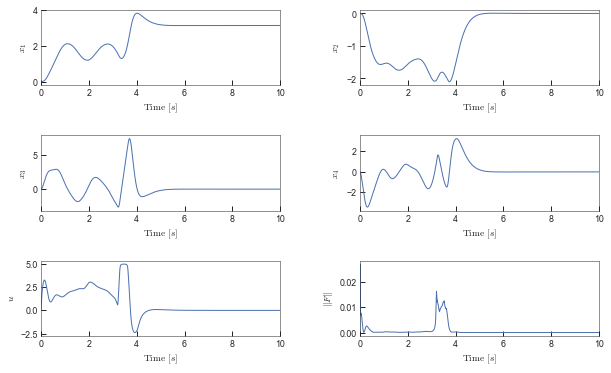

In [19]:
plot = simplot.SimulationPlottor(model_name)
plot.setScales(2,5,2)
plot.showPlots()
# plot.savePlots()